# Final Project: "Modern Portfolio Theory and CAPM"

Konstantin Kujundzic, Matthias Schuch & Orlando Saxer

# Table of contents

1. [Introduction](#Introduction)


2. [Modern Portfolio Theory](#Modern Portfolio Theory)

    2.1. [Data Selection](#Data Selection)
    
    2.2. [Data Transformation and Initial Visualization](#Data Transformation and Initial Visualization)
    
    2.3. [Determining portfolio weights, returns, volatility and Sharpe Ratio](#Determining portfolio weights, returns, volatility and Sharpe Ratio)
    
    2.4. [Plotting the Portfolios to show the Efficient Frontier](#Plotting the Portfolios to show the Efficient Frontier)
    
    2.5. [Plotting special portfolios](#Plotting special portfolios)
    

3. [Capital Asset Pricing Model](#Capital Asset Pricing Model)

    3.1. [Expected Return and Variance](#Expected Return and Variance)
    
    3.2. [Beta coefficient](#Beta coefficient)
    
    3.3. [Calculation of correlation matrix](#Calculation of correlation matrix)
    
    3.4. [Volatility](#Volatility)
    
    3.5. [Example of instability of volatility](#Example of instability of volatility)
    
    
4. [Conclusion and summary](#Conclusion and summary)


5. [Sources](#Sources)

# 1. Introduction <a name = "Introduction"></a>

The Modern Portfolio Theory as developed by Harry Markowitz and - building upon that - the Capital Asset Pricing Model are two very fundamental concepts in today's Corporate Finance world. Both of them find application in a variety of different fields.

Therefore, in this paper, our aim will be to reconstruct both models using Python-specific examples and derive all the relevant results which were discovered by the corresponding researchers.

Thereby, we will start off by providing an introduction to the Modern Portfolio Theory, the coefficient of risk and return as applied by this model and - consequentially - derive the Markowitz Efficient Frontier of portfolios depicting either the highest return for a given level of risk or the lowest risk for a given level of return. This analysis will be carried out by an examplary selection of stocks to demonstrate a rather practice-orientated approach.

Building upon the aforepresented results, we will reproduce the basic assumptions and extensions of the so-called Captial Asset Pricing Model (CAPM) and derive within the framework of a two-asset example the key insights and formulas of the CAPM Theory, which include f.e. the Expected Return equation or the beta coefficient. Moreover, a correlation matrix will be presented as well as a deeper perspective of the topic of volatility, which represents a key point within the context of the CAPM.

Mostly, we will use the API from Quandl, which is an online marketplace for financial, economic and alternative data. Quandl offers a package for Python, but since it is not supported in Jupyter Notebook, we install it through pip. As a next step, the packages that will be needed in this notebook are loaded. Also, other extensions such as the Yahoo Finance import will be utitlized for the purpose of this paper

In [48]:
# Install the quandl pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install quandl
!{sys.executable} -m pip install pandas_datareader
!{sys.executable} -m pip install fix_yahoo_finance

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [49]:
# Import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pandas_datareader import data as pdr
#import fix_yahoo_finance as yf
import statsmodels.api as sm
from statsmodels import regression
%matplotlib inline
import pylab 
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
import scipy.stats as stats
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

Populating the interactive namespace from numpy and matplotlib


# 2. Modern Portfolio Theory <a name = "Modern Portfolio Theory"></a>

In the first part of our project, we will give a simple introduction to the theoretical concepts behind the so-called "Modern Portfolio Theory" or MPT. Harry Markowitz can be considered the inventor of the MPT. He won the Nobel Prize in Economics in 1990. He wrote in 1952, that "since there were two criteria, risk and return, it was natural to assume that investors selected investments from the set of Pareto optimal risk-return combinations." Therefore, optimal portfolios can be constructed for any given level of risk preference. 

In general, the expected portfolio return can be calculated by multiplying the returns of the individual assets with their respective weights:

$$E(R_p)=\displaystyle\sum_{i}w_i*E(R_i)$$

The measure of risk, namely the volatility or the variance's square root, its standard deviation, is defined as follows:

$$\sigma^2_p=\displaystyle\sum_{i}w^2_i\sigma^2_p+\displaystyle\sum_{i}\displaystyle\sum_{i\neq j}w_i w_j \sigma_i \sigma_j \rho_{ij} $$

where $\sigma$ is the standard deviation of an asset, and $\rho$ the standardized coefficient of correlation between two assets. This is particularly important in the context of the Modern Portfolio Theory as it describes the degree of the linear relationship between two assets in a range of -1 to 1. A value of -1 represents perfectly inverse correlation, 0 no correlation at all, and +1 perfectly positive correlation. For all values except +1, one can expect that a stock contributes to lower the portfolio risk. When a correlation coefficient of -1 is existent, one can even eliminiate risk entirely.

The Modern Portfolio Theory suggests the possibility to consequentially construct a so-called "Markowitz Efficient Frontier" of optimal portfolio combinations that either (a) offers the maximum possible return for a certain risk level or (b) provides the lowest level of risk for a given expected return. The rationale behind this concept is that investors can profit from diversification, so by adding multiple stocks into a portfolio whose returns are not perfectly correlated, one can eliminate stock-specific risks and remain solely with the non-diversible market or portfolio risk. Thereby, one of the key insights when selecting stocks for a portfolio is established: not only the risk and return of the stock itself shall be considered, but always its contribution to portfolio risk and return while analyzing its covariance.

In the following section, we will proceed by deriving the said Efficient Frontier and reconstuct Markowitz's results step-by-step using Python code. 

## 2.1. Data Selection <a name = "Data Selection"></a>

We will start off by selecting exemplary stocks which we will analyze in the following section. The cell below allows us to use stocks by their indices, as well as selecting a date range by defining starting and end dates. Additionally, the number of portfolios that should be created can be defined. (A longer date range, more stock indices, and higher number of portfolios will have an impact on computation time.) As an example, we select the stocks for Procter & Gamble (PG), Johnson & Johnson (JNJ), Walmart (WMT) and McDonalds (MCD).

The code below imports the data through the Quandl API.

In [50]:
# Select stocks for portfolio. Other potential indices: 'NFLX', 'AMGN', 'GM', 'GD', 'TSLA', 'FB', 
stocks = ['PG', 'JNJ', 'WMT', 'MCD']

#Select starting and end date

starting_date = '2017-01-01'
end_date = '2017-12-31'

# Set number of portfolios

qty_portfolios = 40000

In [51]:
# Load data from Quandl

# Entering an API key allows unlimited downloads through the Quandl API
quandl.ApiConfig.api_key = '-4QgByxUyc4Wp2pUoTgo'

# Loading the data for the selected stocks
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = {'columns': ['date', 'ticker', 'adj_close']},
                        date = {'gte': starting_date, 'lte': end_date}, paginate=True)

## 2.2. Data Transformation and Initial Visualization <a name = "Data Transformation and Initial Visualization"></a>

As a first step, the dataset is now cleaned up, visualized with a simple plot to confirm the data and some basic math operations are performed, since daily and annual returns and covariances will be needed in the next step. Resulting from that, the closing prices of the aforementioned stocks are depicted in a graph. This initial visualization serves the purpose of confirming, that the data has been imported properly and no anomaly is displayed (such as a company suffering bankruptcy and stock price going to zero).

We will additionally continue by calculating the stocks daily and annual percentage return as well as their daily and annual covariance.

In [52]:
# Set date as index
data_fixdate = data.set_index('date')

# Set stocks as columns
data_clean = data_fixdate.pivot(columns='ticker')

Text(0.5,0,'Date')

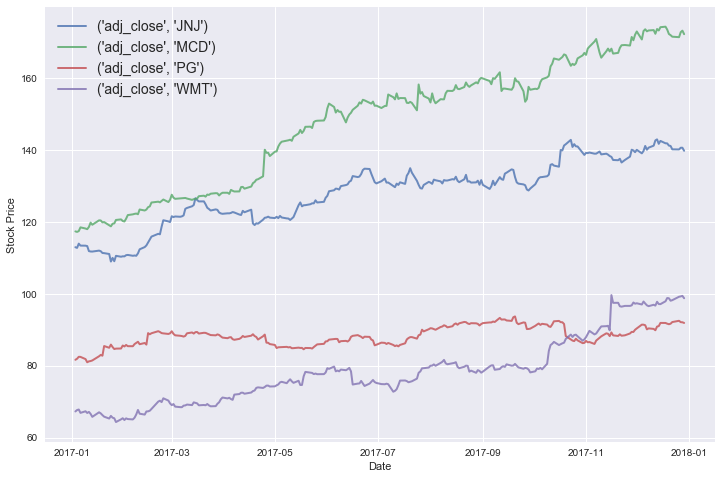

In [53]:
plt.figure(figsize=(12, 8))
for c in data_clean.columns.values:
    plt.plot(data_clean.index, data_clean[c], lw=2, alpha=0.8, label=c)
plt.legend(loc='upper left', fontsize=14)
plt.ylabel('Stock Price')
plt.xlabel('Date')

In [54]:
# Calculate daily and annual returns
daily_returns = data_clean.pct_change()
annual_returns = daily_returns.mean() * 252

# Calculate daily and annual covariance
daily_covariance = daily_returns.cov()
annual_covariance = daily_covariance * 252

## 2.3. Determining portfolio weights, returns, volatility and Sharpe Ratio <a name = "Determining portfolio weights, returns, volatility and Sharpe Ratio"></a>

In the next step we will focus on the calculations of the actual portfolios. Weights of the stock allocations for each portfolios are randomly generated, as well as return, volatility and Sharpe ratio of each portfolio are calculated. In a next step, the data is stored in a dataframe that can be used to vizualize the results.

In [55]:
# Create empty lists for returns, volatility and weights
portfolio_returns = []
portfolio_volatility = []
portfolio_weights = []
portfolio_sharperatio = []

In [56]:
# Calculate portfolio weights, returns, volatility and Sharpe Ratio and add to lists
for single_portfolio in range(qty_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    returns = np.dot(weights, annual_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(annual_covariance, weights)))
    sharperatio = returns / volatility
    portfolio_returns.append(returns)
    portfolio_volatility.append(volatility)
    portfolio_weights.append(weights)
    portfolio_sharperatio.append(sharperatio)

In [57]:
# Create a dictionary for returns and corresponding volatility
portfolio_dict = {'Expected Returns': portfolio_returns,
             'Volatility': portfolio_volatility, 'Sharpe Ratio' : portfolio_sharperatio}

# Add ticker symbol and weight to dictionary
for counter,symbol in enumerate(stocks):
    portfolio_dict[symbol+' Weight'] = [Weight[counter] for Weight in portfolio_weights]
    
# Convert dictionary to a dataframe
df = pd.DataFrame(portfolio_dict)

# Rename and rearrange the columns
portfolio_df = df[['Expected Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in stocks]]

## 2.4. Plotting the Portfolios to show the Efficient Frontier <a name = "Plotting the Portfolios to show the Efficient Frontier"></a>

The randomly generated portfolios will now be visualized, which provides us with a clear outline of the efficient frontier. A scatterplot is used to display the portfolios themselves, with a colormap indicating the Sharpe ratios of the various portfolios. As can be seen in the graph, the portfolios are scattered, with a clear curve forming along their left side. This curve is the efficient frontier. There is no portfolio that could provide a lower volatility, then the ones displayed.

We use a color map to indicate the Sharpe Ratios of the various portfolios. In general, the Sharpe Ratio is a measure of superior return for one unit of risk conferred. It is defined as:

$$Sharpe Ratio = \frac{R_i-R_f}{\sigma_i}$$

A higher Sharpe ratio indicates a more effienct portfolio where the portfolio with the highest Sharpe Ratio representing the so-called Tangency Portfolio and will also be of great use in the next Chapter when the CAPM is discussed. (For simplification, we assume a risk-free rate of zero.)

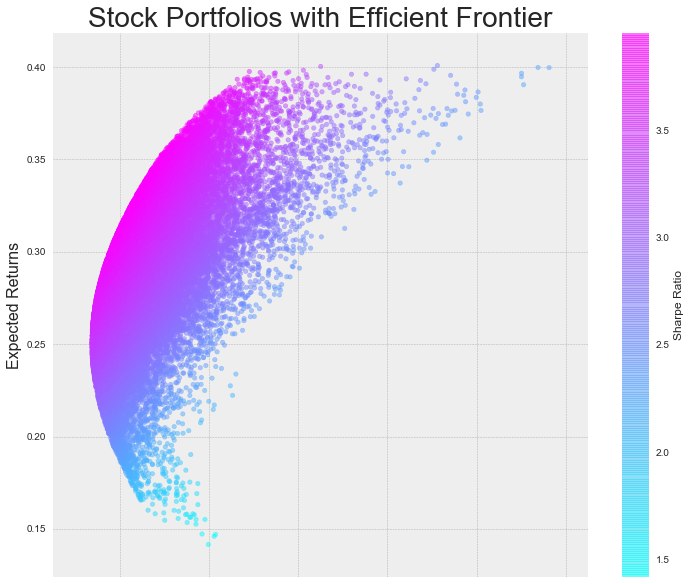

In [58]:
# Plot the portfolio with a color map for the Sharpe Ratio
plt.style.use('bmh')
portfolio_df.plot.scatter(x='Volatility', y='Expected Returns', c='Sharpe Ratio', cmap='cool', alpha=0.5, figsize=(12, 10), grid=True)
plt.xlabel('Standard Deviation', fontsize=16)
plt.ylabel('Expected Returns', fontsize=16)
plt.title('Stock Portfolios with Efficient Frontier', fontsize=28)
plt.show()

## 2.5. Plotting special portfolios <a name = "Plotting special portfolios"></a>

Once we have plotted all the randomly generated portolios, it is worth taking a closer look at two special cases, the minimum variance portfolio and the most efficient portfolio, namely the Tangency Portfolio. 

The minimum variance portfolio is the one that carries the lowest amount of risk compared to all other possible portfolios, which means that it is the furthest towards the left in the graph. The most efficient portfolio - the tangency portfolio providing the higher superior return compared to a standardized risk measure -  is the one with the highest Sharpe ratio. We could more or less identify these portfolios by looking at the graph above, but we will vizualize them below.

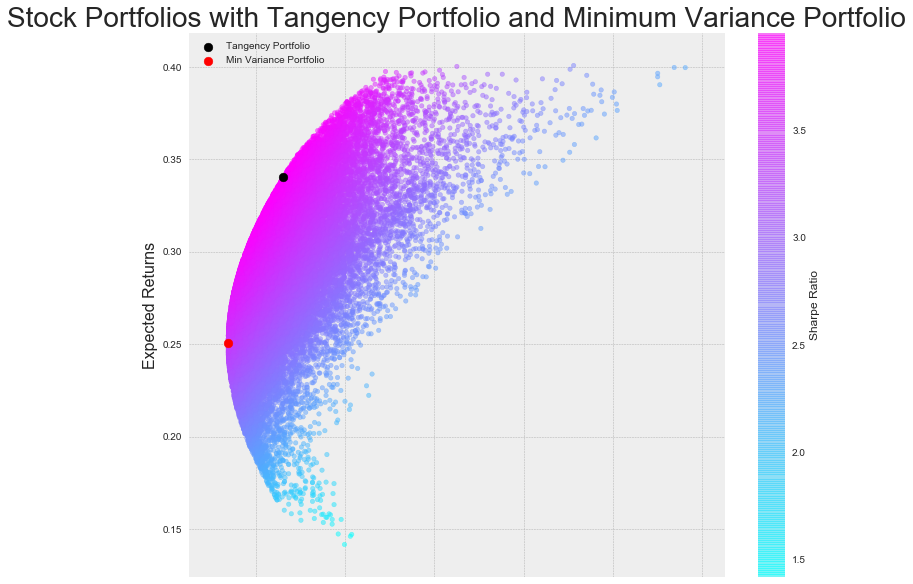

In [59]:
# Calculate special portfolios
min_portfolio_volatility = df['Volatility'].min()
min_variance_portfolio = df.loc[df['Volatility'] == min_portfolio_volatility]
max_portfolio_sharperatio = df['Sharpe Ratio'].max()
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_portfolio_sharperatio]

# Add special portfolios to previous plot
plt.style.use('bmh')
portfolio_df.plot.scatter(x='Volatility', y='Expected Returns', c='Sharpe Ratio', cmap='cool', alpha=0.5, figsize=(12, 10), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Expected Returns'], label='Tangency Portfolio', c='black', marker='.', s=300)
plt.scatter(x=min_variance_portfolio['Volatility'], y=min_variance_portfolio['Expected Returns'], label='Min Variance Portfolio', c='red', marker='.', s=300 )
plt.legend()
plt.xlabel('Standard Deviation', fontsize=16)
plt.ylabel('Expected Returns', fontsize=16)
plt.title('Stock Portfolios with Tangency Portfolio and Minimum Variance Portfolio', fontsize=28)
plt.show()

# 3. Capital Asset Pricing Model <a name = "Capital Asset Pricing Model"></a>

Building upon the Modern Portfolio Theory as discussed in the Chapter before, we will now continue by providing an illustration and expansion of the aforementioned model.

The Capital Asset Pricing Model is one of the most commonly used measures of cost of capital. It is based on the premise of diversification and the underlying distiction between systematic risk and idiosyncratic risk. It is based on the Modern Portfolio Theory and the market / tangency portfolio. Basically, it derives all risk that matters from the co-movement with the market in the so-called beta coefficient which shall be discussed later.

Thereby, the CAPM requires certain assumptions to hold which include:
- Investors are price takers and plan over the same horizon
- No distortionary taxes or transaction costs
- All investors can borrow/lend at the same risk-free rate
- Investors only care about expected return and risk
- All Investors have the same-information and expectations


## 3.1. Expected Return and Variance <a name = "Expected Return and Variance"></a>

The following example shall demonstrate the basic intuition behind the CAPM model and the Modern Portfolio Theory by assuming a simple two-stock portfolio:

Asset 1 and 2 have an annualized returns of 20% and 40%, respectively. The variance of those returns is, 30% for asset 1 and 50% for asset 2. Considering the portfolio consists of 50% of Asset 1 and 50% of Asset 2, the annualized return of our holdings is 30% (The weighted average of the returns of the two assets). The variance of our portfolio will not necessarily be 40%, the weighted average of the two variances. Our overall variance depends on how the two assets are correlated. Mathematically, we have: 

$$\sigma^2_p = Var(w_1 A_1 + w_2 A_2) $$
$$ = Var(w_1 A_1) + Var(w_2 A_2) + 2 Cov(w_1 A_1,w_2 A_2) $$
$$ = w^2_1 Var(A_1) + w^2_1 Var(A_2) + 2 Cov(w_1 A_1,w_2 A_2) $$
$$ = w^2_1 Var(A_1) + w^2_1 Var(A_2) + 2 w_1 w_2\rho  \sigma_1  \sigma_2 $$

, where $\rho$ is the correlation coefficient between asset 1 and asset 2 and $\sigma$ is the respective standard deviation. At this point, here is a table that shows the variance of the portfolio under different correlation between assets 1 and 2: 

In [73]:
var1 = 0.3
var2 = 0.5
sigma1 = 0.5477
sigma2 = 0.707
w1 = 0.5
w2 = 0.5
rho = np.array([-1, -0.5, 0, 0.5, 1])
var = (w1**2)*var1 + (w2**2)*var2 + 2*w1*w2*rho*sigma1*sigma2
print ('Portfolio Variance: ', var)
print ('Correlation coefficents: ', rho)

Portfolio Variance:  [0.00638805 0.10319403 0.2        0.29680597 0.39361195]
Correlation coefficents:  [-1.  -0.5  0.   0.5  1. ]


As the number of assets held in the portfolio increases, the overall risk of the portfolio declines. However, it does not tend towards zero, as there are certain risks, that cannot be diversified away in our setting. This makes us introduce the distinction between idiosyncratic risk and systematic risk. Idiosyncratic risk referes to the firm-specific risk, the risk that can be diversified away. Systematic risk is market-wide and affects all participants. 

So as our portfolio grows larger and more independent bets are made through diversification, the variance declines. It declines to the point, where the portfolio variance equals the systematic risk. Under this logic, we can conclude, that investors should not get compensated for taking idiosyncratic risk, but only for systematic risk. In equation form, we have: 

$$ E[Return]= Risk-Free Rate of Return + Risk Premium $$ 

The expected return of an investment in any asset class can be decomposed into its constitutuent factors. Speaking of an investment in equities, we need to be compensated for taking systematic risk. After adjusting the risk premium for the codependance of the individual asset-class return with the overall market return, we have: 

$$ Risk Premium of Asseti=β(Market Risk Premium) $$

This is the CAPM model. We can further express it more accurately, as: 

$$ E[R_i]=R_F+ \beta (E[R_M]−R_F) $$

, where $R_F$ is the risk-free rate, $R_M$ is the expected market return and $R_i$ is the individual expected asset return under the model. 

## 3.2. Beta coefficient <a name = "Beta coefficient"></a>

We can proceed to show - as an example for demonstration - the various betas for different sectors of the economy. We will work with the following sectors: Consumer Discretionary (XLY), Financials (XLF), Healthcare (XLV), Information Technology (XLK), Industrials (XLI), Materials (XLB), Energy (XLE) and  Utilities (XLU). As a proxy for the overall market we will use the S&P 500 Index (SPY). Note that, we are looking at sectors of the economy of the United States. 

Throughout this paper, we will also show multiple methods to import financial data into our notebook. It is often the case, that one database does not contain all the needed data, so that multiple sources need to be used. 

In [74]:
# the old yahoo finance api does not work anymore, so this is the fix for it. 
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
# download Panel
data = pdr.get_data_yahoo(['XLY', 'XLF', 'XLV', 'XLK', 'XLP', 'XLI', 'XLB', 'XLE', 'XLU', 'SPY'], start="2013-12-01", end="2018-12-01")
rf_rate = pdr.get_data_yahoo('^IRX', start = '2013-01-01', end = '2018-12-01')

[*********************100%***********************]  10 of 10 downloaded
[*********************100%***********************]  1 of 1 downloaded


We now analyze the individual betas of the sectors. To run regressions, we first need to transform the end of day closing prices into daily returns. After doing that, we will use the CAPM model and run an OLS regression using the individual sector daily returns as predicted variable and the daily market returns as explanatory variable. 

In [75]:
SPY_r = (data.Close['SPY'] - data.Close['SPY'].shift(1)) / data.Close['SPY'].shift(1)
SPY_r = SPY_r.dropna()

XLY_r = (data.Close['XLY'] - data.Close['XLY'].shift(1)) / data.Close['XLY'].shift(1)
XLY_r = XLY_r.dropna()

rf_rate.Close = rf_rate.Close / 100

0.9999849525694948


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     9949.
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        09:34:04   Log-Likelihood:                 5220.1
No. Observations:                1258   AIC:                        -1.044e+04
Df Residuals:                    1256   BIC:                        -1.043e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.474e-05      0.000      0.531      0.595      -0.000       0.000
0              1.0000      0.010     99.745      0.000       0.980       1.020
==============================================================================
Omnibus:                       25.239   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.639
Skew:                          -0.122   Prob(JB):                     2.03e-10
Kurtosis:                       3.890   Cond. No.                         93.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

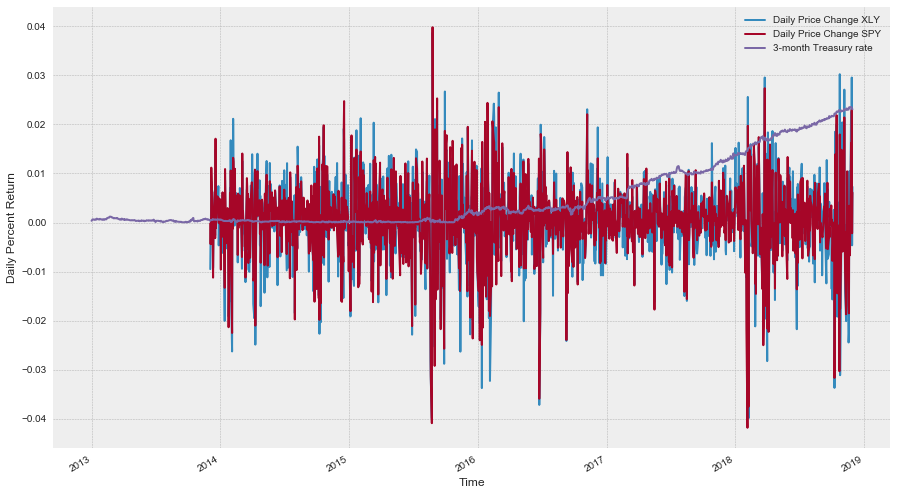

In [76]:
y = XLY_r - rf_rate.Close # <-- response
y = y.dropna()
X = SPY_r - rf_rate.Close # <-- predictor
X = X.dropna()

X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X)
results = model.fit()
XLY_beta = results.params[1]

XLY_r.plot(label='Daily Price Change XLY')
SPY_r.plot(label='Daily Price Change SPY')
rf_rate.Close.plot(label='3-month Treasury rate')
plt.xlabel('Time')
plt.ylabel('Daily Percent Return')
plt.legend();

print (XLY_beta)

results.summary()

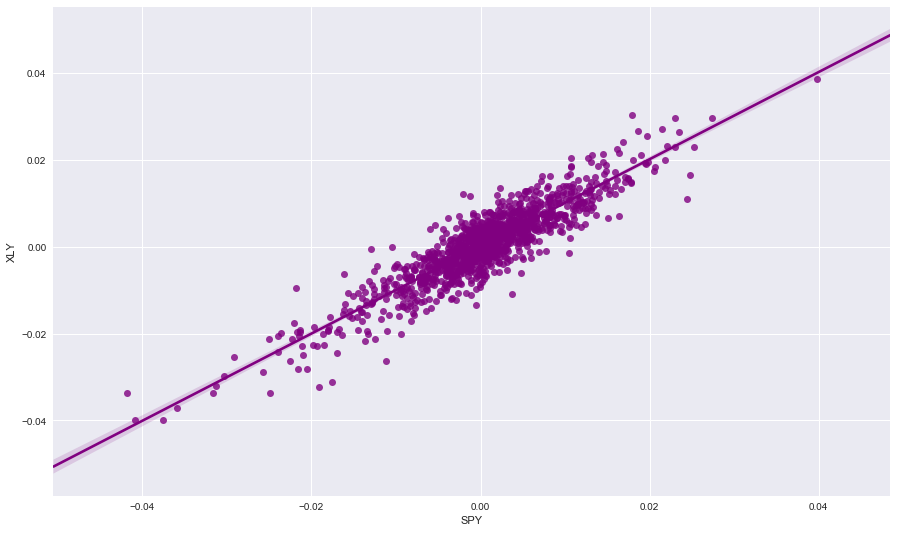

In [77]:
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x=SPY_r, y=XLY_r, color='purple')


From the results, we can see, that the Consumer Discreationary sector behaves similarly to the market on a daily basis. Analyzing how the daily performance of XLY covaries with the overall market indicates a statistically significant beta of 1. 

Securites with betas higher than 1, exhibit higher variations in returns than the overall market. If the market on any given day goes up by 1%, the price of the securities will tend to go up more than 1% on such given days. The converse is true, for betas lower than 1. 

We can continue to calculate the betas for all the sectors. To show that betas are not static and change over time we calculate the 3-month (90 trading days) rolling betas.  

In [78]:
data_return = (data.Close - data.Close.shift(1)) / data.Close.shift(1)
# We need to first clean up the data and put it into a better format to do our calculations
rdata = data_return.dropna()
rdata.head()

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2013-12-03,-0.004321,-0.011757,0.002428,-0.010247,-0.008567,0.002313,0.004909,0.005017,-0.008683,-0.009496
2013-12-04,-0.000111,0.004804,-0.003229,0.002353,-0.004019,0.000866,-0.002326,0.004467,-0.003467,-0.002319
2013-12-05,-0.004395,-0.005692,-0.003355,-0.009390,0.000404,-0.003171,-0.009093,-0.008109,-0.001831,0.001085
2013-12-06,0.011177,0.013739,0.003134,0.013744,0.015329,0.006940,0.013647,0.013713,0.013025,0.008360
2013-12-09,0.002542,0.005195,0.001389,0.004207,0.002582,0.003159,0.003482,-0.005983,0.001992,-0.000768


We need to change the format of our data to facilitate the calculation of rolling betas on all the sectors. 

In [79]:
sdata = rdata.drop(columns = ['SPY'])
sdata_stack = sdata.stack()
sdata_stack.head()

Date           
2013-12-03  XLB   -0.011757
            XLE    0.002428
            XLF   -0.010247
            XLI   -0.008567
            XLK    0.002313
dtype: float64

In [80]:
# transpose the columns so to stack them on each other
sdata_stack = sdata.stack()
sdata_stack = sdata_stack.to_frame()
sdata_stack = sdata_stack.reset_index()
sdata_stack.columns = ['Date', 'asset', 'stock_returns']

sdata_stack.head()

,Date,asset,stock_returns
0,2013-12-03,XLB,-0.011757
1,2013-12-03,XLE,0.002428
2,2013-12-03,XLF,-0.010247
3,2013-12-03,XLI,-0.008567
4,2013-12-03,XLK,0.002313


In [81]:
# reorder the SPY data so to then merge it with our newly stacked data
rdata = rdata.reset_index()
rdata.columns = ['Date', 'SPY','XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
print (list(rdata))
spy = rdata.drop(columns = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'] )
spy.head()

['Date', 'SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']


,Date,SPY
0,2013-12-03,-0.004321
1,2013-12-04,-0.000111
2,2013-12-05,-0.004395
3,2013-12-06,0.011177
4,2013-12-09,0.002542


In [82]:
merged_df = pd.merge(sdata_stack, spy, on='Date')
merged_df.columns = ['Date', 'asset', 'stock_returns', 'market_returns']
merged_df.tail()

,Date,asset,stock_returns,market_returns
11326,2018-11-30,XLK,0.009510,0.006095
11327,2018-11-30,XLP,0.006440,0.006095
11328,2018-11-30,XLU,0.014786,0.006095
11329,2018-11-30,XLV,0.020328,0.006095
11330,2018-11-30,XLY,0.007275,0.006095


In [83]:
merged_df['stock_returns'].describe()

count    11331.000000
mean         0.000325
std          0.009800
min         -0.064244
25%         -0.004464
50%          0.000691
75%          0.005657
max          0.050826
Name: stock_returns, dtype: float64

In [84]:
merged_df = merged_df.sort_values(by = ['asset', 'Date'])
merged_df.head()

,Date,asset,stock_returns,market_returns
0,2013-12-03,XLB,-0.011757,-0.004321
9,2013-12-04,XLB,0.004804,-0.000111
18,2013-12-05,XLB,-0.005692,-0.004395
27,2013-12-06,XLB,0.013739,0.011177
36,2013-12-09,XLB,0.005195,0.002542


At this point we can calculate the rolling betas on our newly organized dataframe. The function to calculate the beta is simple since we are using an OLS simple linear regression. 

$$ \beta_1 = Cov(stock returns, market returns) / Var(market returns) $$

We can also calculate the betas on different rolling periods. Here we show the 30, 60 and 90-Day rolling betas for our sectors. 

In [85]:
merged_df['beta30'] = merged_df['stock_returns'].rolling(window=30).cov(other=merged_df['market_returns']) / merged_df['market_returns'].rolling(window=30).cov(other=merged_df['market_returns'])
merged_df['beta60'] = merged_df['stock_returns'].rolling(window=60).cov(other=merged_df['market_returns']) / merged_df['market_returns'].rolling(window=60).cov(other=merged_df['market_returns'])
merged_df['beta90'] = merged_df['stock_returns'].rolling(window=90).cov(other=merged_df['market_returns']) / merged_df['market_returns'].rolling(window=90).cov(other=merged_df['market_returns'])
merged_df.tail()

,Date,asset,stock_returns,market_returns,beta30,beta60,beta90
11294,2018-11-26,XLY,0.022447,0.016144,1.163907,1.136283,1.131278
11303,2018-11-27,XLY,0.002972,0.003364,1.167553,1.135111,1.130719
11312,2018-11-28,XLY,0.029535,0.023025,1.205278,1.147605,1.142076
11321,2018-11-29,XLY,-0.004642,-0.002185,1.207409,1.146100,1.148093
11330,2018-11-30,XLY,0.007275,0.006095,1.200856,1.146885,1.150942


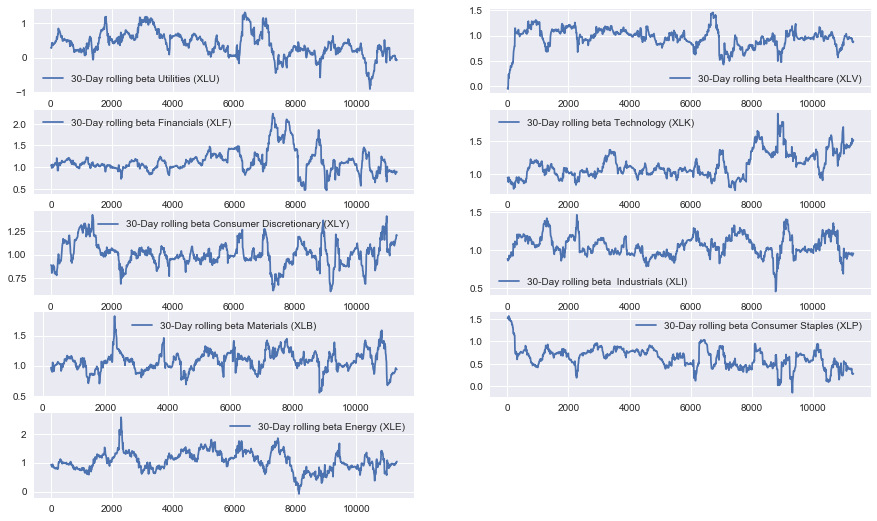

In [86]:
plt.figure(1)
plt.subplot(521)
d1 = merged_df[merged_df.asset == 'XLU'].beta30.plot(label = '30-Day rolling beta Utilities (XLU)')
plt.legend()
plt.subplot(522)
d2 = merged_df[merged_df.asset == 'XLV'].beta30.plot(label = '30-Day rolling beta Healthcare (XLV)')
plt.legend()
plt.subplot(523)
d3 = merged_df[merged_df.asset == 'XLF'].beta30.plot(label = '30-Day rolling beta Financials (XLF)')
plt.legend()
plt.subplot(524)
d4 = merged_df[merged_df.asset == 'XLK'].beta30.plot(label = '30-Day rolling beta Technology (XLK)')
plt.legend()
plt.subplot(525)
d5 = merged_df[merged_df.asset == 'XLY'].beta30.plot(label = '30-Day rolling beta Consumer Discretionary (XLY)')
plt.legend()
plt.subplot(526)
d6 = merged_df[merged_df.asset == 'XLI'].beta30.plot(label = '30-Day rolling beta  Industrials (XLI)')
plt.legend()
plt.subplot(527)
d7 = merged_df[merged_df.asset == 'XLB'].beta30.plot(label = '30-Day rolling beta Materials (XLB)')
plt.legend()
plt.subplot(528)
d8 = merged_df[merged_df.asset == 'XLP'].beta30.plot(label = '30-Day rolling beta Consumer Staples (XLP)')
plt.legend()
plt.subplot(529)
d9 = merged_df[merged_df.asset == 'XLE'].beta30.plot(label = '30-Day rolling beta Energy (XLE)')
plt.legend()
plt.show()

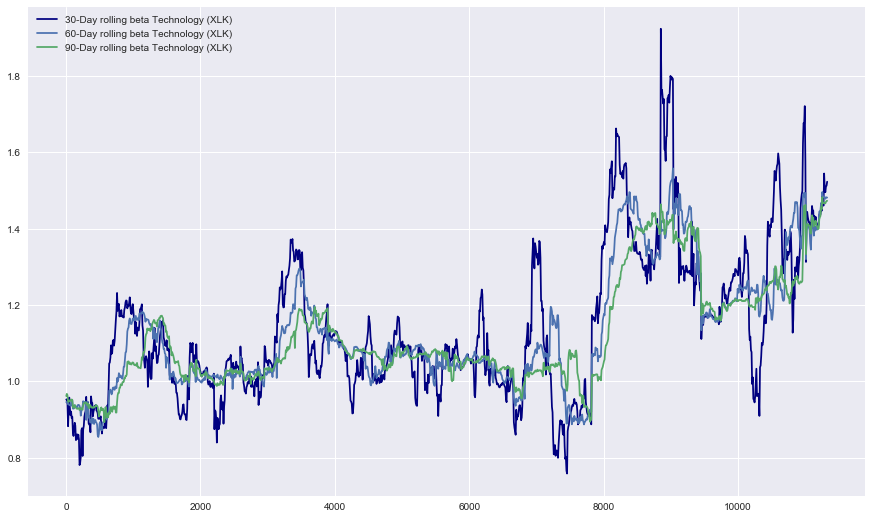

In [87]:
XLK_beta30 = merged_df[merged_df.asset == 'XLK'].beta30.plot(label = '30-Day rolling beta Technology (XLK)', colormap='jet')
XLK_beta60 = merged_df[merged_df.asset == 'XLK'].beta60.plot(label = '60-Day rolling beta Technology (XLK)')
XLK_beta90 = merged_df[merged_df.asset == 'XLK'].beta90.plot(label = '90-Day rolling beta Technology (XLK)')
plt.legend()
plt.show()

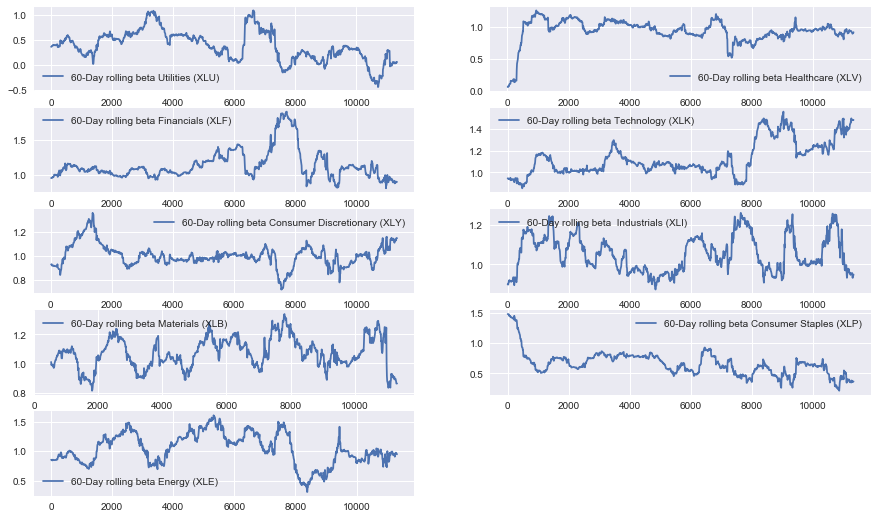

In [88]:
plt.figure(1)
plt.subplot(521)
d1 = merged_df[merged_df.asset == 'XLU'].beta60.plot(label = '60-Day rolling beta Utilities (XLU)')
plt.legend()
plt.subplot(522)
d2 = merged_df[merged_df.asset == 'XLV'].beta60.plot(label = '60-Day rolling beta Healthcare (XLV)')
plt.legend()
plt.subplot(523)
d3 = merged_df[merged_df.asset == 'XLF'].beta60.plot(label = '60-Day rolling beta Financials (XLF)')
plt.legend()
plt.subplot(524)
d4 = merged_df[merged_df.asset == 'XLK'].beta60.plot(label = '60-Day rolling beta Technology (XLK)')
plt.legend()
plt.subplot(525)
d5 = merged_df[merged_df.asset == 'XLY'].beta60.plot(label = '60-Day rolling beta Consumer Discretionary (XLY)')
plt.legend()
plt.subplot(526)
d6 = merged_df[merged_df.asset == 'XLI'].beta60.plot(label = '60-Day rolling beta  Industrials (XLI)')
plt.legend()
plt.subplot(527)
d7 = merged_df[merged_df.asset == 'XLB'].beta60.plot(label = '60-Day rolling beta Materials (XLB)')
plt.legend()
plt.subplot(528)
d8 = merged_df[merged_df.asset == 'XLP'].beta60.plot(label = '60-Day rolling beta Consumer Staples (XLP)')
plt.legend()
plt.subplot(529)
d9 = merged_df[merged_df.asset == 'XLE'].beta60.plot(label = '60-Day rolling beta Energy (XLE)')
plt.legend()
plt.show()

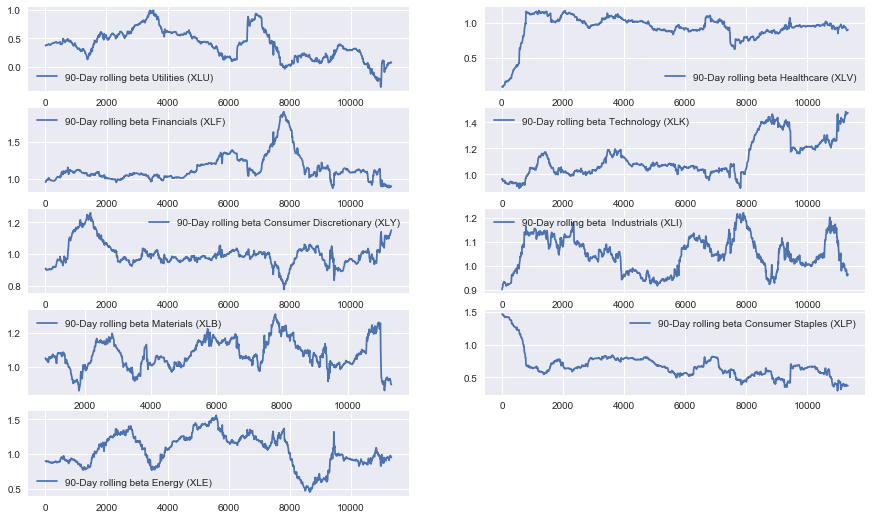

In [89]:
plt.figure(1)
plt.subplot(521)
d1 = merged_df[merged_df.asset == 'XLU'].beta90.plot(label = '90-Day rolling beta Utilities (XLU)')
plt.legend()
plt.subplot(522)
d2 = merged_df[merged_df.asset == 'XLV'].beta90.plot(label = '90-Day rolling beta Healthcare (XLV)')
plt.legend()
plt.subplot(523)
d3 = merged_df[merged_df.asset == 'XLF'].beta90.plot(label = '90-Day rolling beta Financials (XLF)')
plt.legend()
plt.subplot(524)
d4 = merged_df[merged_df.asset == 'XLK'].beta90.plot(label = '90-Day rolling beta Technology (XLK)')
plt.legend()
plt.subplot(525)
d5 = merged_df[merged_df.asset == 'XLY'].beta90.plot(label = '90-Day rolling beta Consumer Discretionary (XLY)')
plt.legend()
plt.subplot(526)
d6 = merged_df[merged_df.asset == 'XLI'].beta90.plot(label = '90-Day rolling beta  Industrials (XLI)')
plt.legend()
plt.subplot(527)
d7 = merged_df[merged_df.asset == 'XLB'].beta90.plot(label = '90-Day rolling beta Materials (XLB)')
plt.legend()
plt.subplot(528)
d8 = merged_df[merged_df.asset == 'XLP'].beta90.plot(label = '90-Day rolling beta Consumer Staples (XLP)')
plt.legend()
plt.subplot(529)
d9 = merged_df[merged_df.asset == 'XLE'].beta90.plot(label = '90-Day rolling beta Energy (XLE)')
plt.legend()
plt.show()


## 3.3. Calculation of correlation matrix <a name = "Calculation of correlation matrix"></a>

To get a better idea of the behavior of the different sectors, we can visualize them through a correlation matrix, which shows comovement between all the sectors in one chart, making it simpler to analyze the data. 

In [90]:
# let us begin with initial downloaded data
sec = data.Close
sec_r = pd.DataFrame()
for stock in sec: 
    if stock not in sec_r: 
        sec_r[stock] = np.log(sec[stock]).diff()
sec_r.head()        

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2013-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-03,-0.004330,-0.011826,0.002425,-0.010300,-0.008604,0.002311,0.004897,0.005005,-0.008721,-0.009542
2013-12-04,-0.000111,0.004793,-0.003234,0.002350,-0.004027,0.000865,-0.002329,0.004457,-0.003473,-0.002322
2013-12-05,-0.004405,-0.005708,-0.003361,-0.009434,0.000403,-0.003176,-0.009135,-0.008142,-0.001833,0.001084
2013-12-06,0.011115,0.013646,0.003130,0.013651,0.015212,0.006916,0.013555,0.013620,0.012941,0.008326


In [91]:
sec_r.describe()

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,0.000336,0.000167,-0.000214,0.000346,0.000293,0.000536,0.000218,0.000305,0.000437,0.000400
std,0.008066,0.010129,0.013079,0.010303,0.009131,0.010034,0.007308,0.009050,0.009393,0.008957
min,-0.042722,-0.044967,-0.066400,-0.055068,-0.046453,-0.049674,-0.038417,-0.042058,-0.045321,-0.040760
25%,-0.002990,-0.005216,-0.006981,-0.004585,-0.004044,-0.003833,-0.003671,-0.004651,-0.004185,-0.004057
50%,0.000483,0.000650,0.000000,0.000456,0.000752,0.000928,0.000368,0.000900,0.000801,0.000971
75%,0.004538,0.006020,0.006904,0.005950,0.005404,0.005849,0.004529,0.005858,0.005778,0.005358
max,0.039019,0.034737,0.049576,0.041642,0.031155,0.049169,0.029962,0.026591,0.041787,0.037959


In [92]:
sec_corr = sec_r.corr()
sec_corr

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
SPY,1.000000,0.835840,0.684906,0.861701,0.905456,0.911544,0.714661,0.363101,0.839415,0.904263
XLB,0.835840,1.000000,0.720262,0.733690,0.836706,0.703202,0.546761,0.249697,0.643199,0.723413
XLE,0.684906,0.720262,1.000000,0.580048,0.643049,0.528757,0.393255,0.211591,0.482522,0.552494
XLF,0.861701,0.733690,0.580048,1.000000,0.816028,0.703474,0.538099,0.172844,0.683109,0.752870
XLI,0.905456,0.836706,0.643049,0.816028,1.000000,0.772613,0.614793,0.285417,0.713889,0.802003
XLK,0.911544,0.703202,0.528757,0.703474,0.772613,1.000000,0.584886,0.275608,0.719587,0.833046
XLP,0.714661,0.546761,0.393255,0.538099,0.614793,0.584886,1.000000,0.566387,0.599880,0.626410
XLU,0.363101,0.249697,0.211591,0.172844,0.285417,0.275608,0.566387,1.000000,0.298150,0.266840
XLV,0.839415,0.643199,0.482522,0.683109,0.713889,0.719587,0.599880,0.298150,1.000000,0.724299
XLY,0.904263,0.723413,0.552494,0.752870,0.802003,0.833046,0.626410,0.266840,0.724299,1.000000


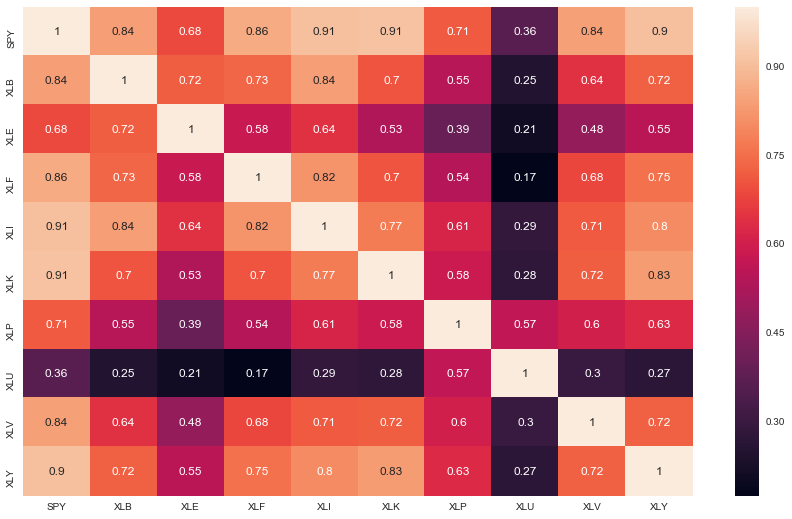

In [93]:
# plot the heatmap and annotation on it with seaborn
sns.heatmap(sec_corr, xticklabels=sec_corr.columns, yticklabels=sec_corr.columns, annot=True)

From our correlation map, we observe that the utilities sector has the lowest correlation pairs. The correlation is the lowest between the financials sector (XLF) and the utilities sector (XLU), a sign that represents the defensive character of utilities stocks and the cyclical character of financials. We find the highest correlation between the overall market (SPY) and the consumer discretionary sector (XLY). Holding positions in both securities provides us with little diversification. The correlation is also high between the information technology sector (XLK) and the overall market. A prolonged analysis of the various correlations follows. 

In [94]:
# 1 month rolling correlation of sectors to overall market (SPY)
rolling_corr20 = pd.DataFrame()
for stock in sec_r: 
    if stock not in rolling_corr20: 
        rolling_corr20[stock] = sec_r.SPY.rolling(window=20).corr(sec_r[stock])

# 3 month rolling correlation of sectors to overall market (SPY)
rolling_corr60 = pd.DataFrame()
for stock in sec_r: 
    if stock not in rolling_corr60: 
        rolling_corr60[stock] = sec_r.SPY.rolling(window=60).corr(sec_r[stock])

# 6 month rolling correlation of sectors to overall market (SPY)
rolling_corr120 = pd.DataFrame()
for stock in sec_r: 
    if stock not in rolling_corr120: 
        rolling_corr120[stock] = sec_r.SPY.rolling(window=120).corr(sec_r[stock])


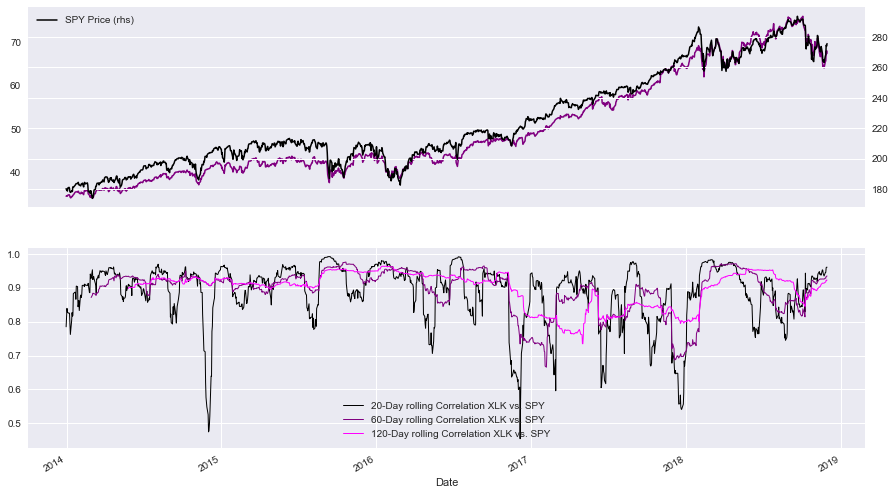

In [95]:
plt.figure(1)
plt.subplot(211)
p1 = sec.XLK.plot(color = 'purple', label = 'Technology XLK (lhs)', linewidth=1.5)
p2 = sec.SPY.plot(secondary_y = True, color = 'black', label = 'SPY Price (rhs)', linewidth=1.5)
plt.legend(loc='best')

plt.subplot(212)
p3 = rolling_corr20.XLK.plot(color = 'black', label = '20-Day rolling Correlation XLK vs. SPY', linewidth=1)
p4 = rolling_corr60.XLK.plot(color = 'purple', label = '60-Day rolling Correlation XLK vs. SPY', linewidth=1)
p5 = rolling_corr120.XLK.plot(color = 'magenta', label = '120-Day rolling Correlation XLK vs. SPY', linewidth=1)
plt.legend(loc='best')
plt.show()

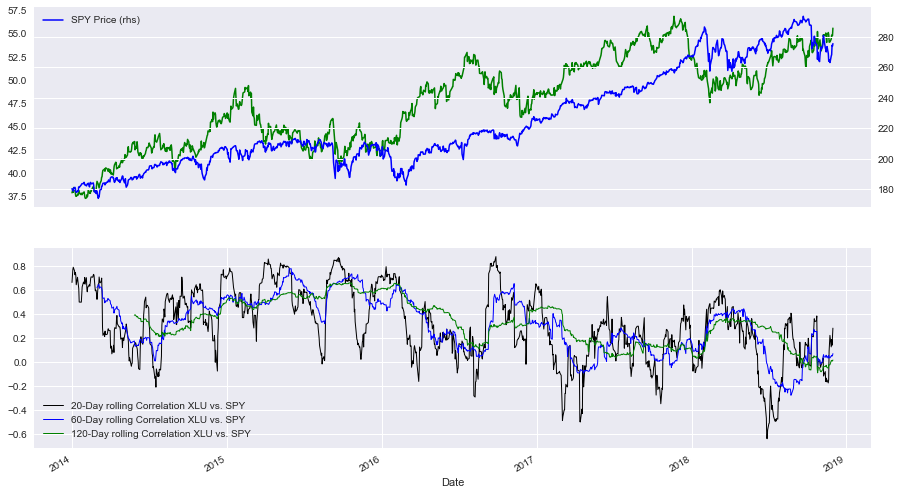

In [96]:
plt.figure(1)
plt.subplot(211)
p1 = sec.XLU.plot(color = 'green', label = 'Utilities sector (XLU) (lhs)', linewidth=1.5)
p2 = sec.SPY.plot(secondary_y = True, color = 'blue', label = 'SPY Price (rhs)', linewidth=1.5)
plt.legend(loc='best')

plt.subplot(212)
p3 = rolling_corr20.XLU.plot(color = 'black', label = '20-Day rolling Correlation XLU vs. SPY', linewidth=1)
p4 = rolling_corr60.XLU.plot(color = 'blue', label = '60-Day rolling Correlation XLU vs. SPY', linewidth=1)
p5 = rolling_corr120.XLU.plot(color = 'green', label = '120-Day rolling Correlation XLU vs. SPY', linewidth=1)
plt.legend(loc='best')
plt.show()

At this point the important observation to make, is that correlations are not static. They change. When constructing portfolios one needs to be wary of 'false' diversification. Even if portfolios where built using asset classes or styles where the long-term correlations were low, the unfortunate reality is that correlations spiked in the midst of a crisis. During a major market sell-off, investors tend to panic and deleverage their portfolios by selling across asset classes, so that the benefits of diversification tend to evaporate, when they are more needed. As we will see in the next section, in times of crisis, volatilities tend to spike many multiples of standard deviation from their mean. With that, the correlation across asset-classes increases and thus quickly increasing the variance of our portfolio. With the increased variance of the portfolio, investors tend to reduce their exposure to that portfolio by selling their positions to increase cash. One can see that this quickly develops a self-fulfilling feedbackloop. 

Recall that, under the CAPM, the return an investor should expect to receive from a stock is just the short term risk free rate (t-bill) plus some proportion of the stock markets overall performance. We called beta that proportion. Under this theory, there is no need to study the fundamentals of the companies in our portfolio. The investor just calculates the beta coefficient, checks the t-bill rate and makes a forecast on how the overall stock market will do based on the economy. These three things will give him an expectancy for the returns in the interested securities. 

However, persistent anomalies have been found that do not fit or contradict the CAPM model. Among them are the 3 factors intially tested by Fama and French in their seminal work on market efficiency: the P/E effect, the Small-firm in January effect, the market-to-book value effect. As a reminder, these effects should not matter to returns on a consistent basis according to the CAPM. Studies have found that companies with lower price to earnings ratios have outperformed those with higher ratios. This is somewhat common sense, in that, a stock for which you overpay from the beginning is less likely to give you a profit. There is also a clear tendency for the market to rally every January. Small-company stocks tend to outperform large companies during this period. As for the market-to-book value effect, companies with lower ratios outperform companies with larger ratios. In the paper by Fama and French from 1992, they looked at the P/E and market-to-book ratio and found, after having isolated the sample from unintentional biases, that those two factors alone could account for most of what differentiated the profitability of one stock from another. In fact, beta was redundant. Their work has earned the shorthand title among economists as the 'beta is dead paper'. 


## 3.4. Volatility <a name = "Volatility"></a>
Let us first look at the original data and then explore the concept of volatiltiy. This is essential to understand the assumption behind modern portfolio theory, CAPM and Efficient Frontiers. 

In all these Model, at least on the basic level (without looking at GARCH, FIGARCH and MMAR Models) it is assumed that the variance is finite and constant. We will now explore why this is not the case in reality and so why all these models do not work and the underlying assumptions need to be handicapped. 

We will be only looking at the general Stock market and not at individual securities. As a proxy for the overall stock market we will use the S&P 500 Index, a broad based market capitalization weighted index of the 500 largest companies in the United States. 

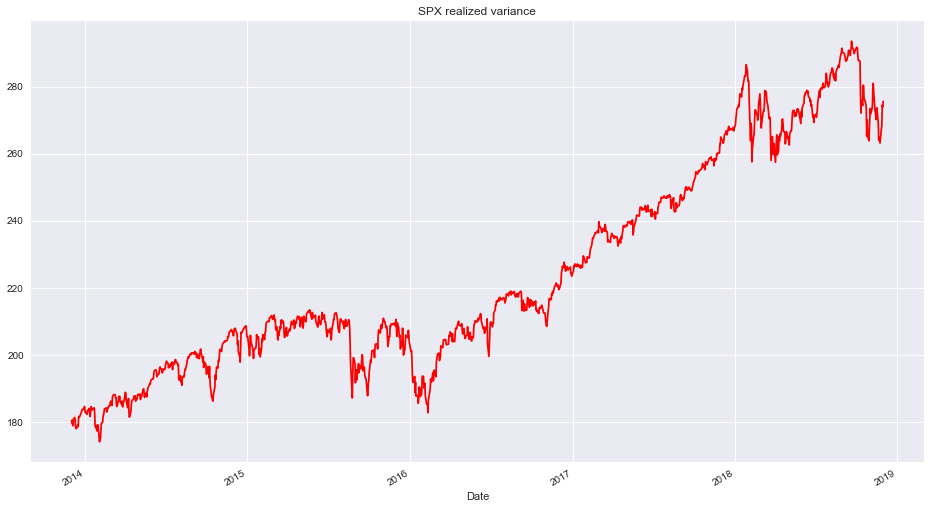

In [97]:
data.Close['SPY'].plot(color='red', grid=True, title='SPX realized variance',
         figsize=(16, 9))


In [98]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.mlab import stineman_interp
import pandas as pd
from pandas_datareader import data, wb
import requests
import zipfile as zi 
import io
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns; sns.set()
%matplotlib inline

In [99]:
url = 'https://realized.oxford-man.ox.ac.uk/images/'
url += 'oxfordmanrealizedvolatilityindices-0.2-final.zip'
data = requests.get(url, stream=True).content
z = zi.ZipFile(io.BytesIO(data))
z.extractall()

In [100]:
df = pd.read_csv('OxfordManRealizedVolatilityIndices.csv', index_col=0, header=2 )
rv1 = pd.DataFrame(index=df.index)
for col in df.columns:
    if col[-3:] == '.rk':
        rv1[col] = df[col]
rv1.index = [dt.datetime.strptime(str(date), "%Y%m%d") for date in rv1.index.values]

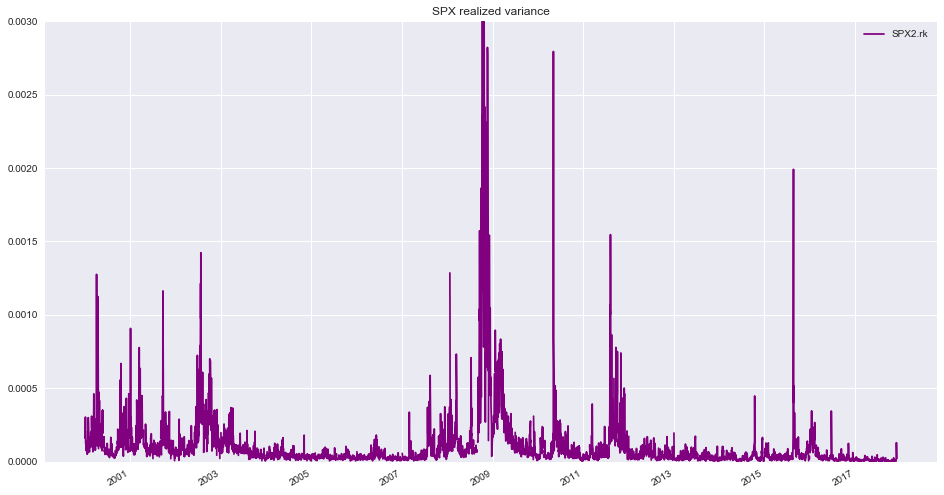

In [101]:
spx = pd.DataFrame(rv1['SPX2.rk'])
spx.plot(color='purple', grid=True, title='SPX realized variance',
         figsize=(16, 9), ylim=(0,0.003));

In [102]:
plt.hist(data.Close['SPY'], bins = 25)
plt.xlabel('nominal levels')
plt.ylabel('Frequency of daily Closing Price of S&P 500 Index')
plt.title('Original Data')

AttributeError: 'bytes' object has no attribute 'Close'

In [103]:
stats.probplot(data.Close['SPY'], dist="norm", plot=pylab)
pylab.show()

AttributeError: 'bytes' object has no attribute 'Close'

In [104]:
data.Close['SPY'].describe()

AttributeError: 'bytes' object has no attribute 'Close'

In [105]:
result = seasonal_decompose(data.Close['SPY'], model='multiplicative', freq=1)
result.plot()
pyplot.show()

AttributeError: 'bytes' object has no attribute 'Close'

At this point it is important to note, that we cannot work with 'level' data. Looking at the absolute price of the S&P 500 Index does not lead to any relevant statistical observations. Therefore, we transform the data into daily price changes and analyze the statistical results in the following section.

We will now transform the data and calculate the daily log returns of the S&P 500 Index. 

In [106]:
# SPY['log_ret'] = np.log(SPY) - np.log(SPY.shift(1)) --> So daily LOG RETURNS

SPY_log = np.log(data.Close['SPY'])
SPY_log_shift = np.log(data.Close['SPY'].shift(1))
SPY_log_returns = SPY_log - SPY_log_shift


plt.plot(SPY_log_returns, color = 'purple')

SPY_log_returns = SPY_log_returns.dropna()

AttributeError: 'bytes' object has no attribute 'Close'

In [107]:
plt.hist(SPY_log_returns, bins = 25)
plt.ylabel('Frequency of S&P 500 log returns')
plt.title('Transformed Data')
# mu = np.mean(SPY_log_returns)
# sigma = np.std(SPY_log_returns)
# print (mu, sigma)
# import matplotlib.mlab as mlab
# bins = 25
# y = mlab.normpdf(bins, mu, sigma)
# print (y)
# l = plt.plot(bins, y, 'r--', linewidth=1)
plt.show()

NameError: name 'SPY_log_returns' is not defined

In [108]:
stats.probplot(SPY_log_returns, dist="norm", plot=pylab)
pylab.show()

NameError: name 'SPY_log_returns' is not defined

From the histogram and the probability plot, we note that the daily returns of the index exhibit extreme negative daily returns. The returns series is negatively skewed, meaning that in some instances (moments of crisis) the S&P 500 index had negative returns of a multiple of its standard deviation. Considering the short period consulted in the data, this should have not happened under a normal distribution. 

In [109]:
SPY_log_returns.describe()

NameError: name 'SPY_log_returns' is not defined

In [110]:
# note that hear we use the additive decomposition method, since there is no need to assume that with the passage of time the 
# daily variation of the prices will increase (no economic sense)

result = seasonal_decompose(SPY_log_returns, model='additive', freq=1)
result.plot()
pyplot.show()

NameError: name 'SPY_log_returns' is not defined

Another interesting illustration is looking at the Dow Jones Industrial Average Index, an index that was created before the S&P 500, so that we can look at more events in their development. 

In [111]:
#download the Dow Jones Industrial Average
yf.pdr_override()
# download 
dow = pdr.get_data_yahoo('^DJI')

OverflowError: mktime argument out of range

In [112]:
# calculate the log returns 
dow_log = np.log(dow.Close)
dow_log_shift = np.log(dow.Close.shift(1))
dow_log_returns = dow_log - dow_log_shift

plt.figure (1)
plt.subplot(311)
p1 = dow.Close.plot(color ='purple', label='The Dow Industrial Average, 1986-2019')
plt.legend(loc='best')

plt.subplot(312)
p2 = dow_log.plot(color= 'purple', label = 'The Dow Industrial Average in log scale')
plt.legend(loc='best')

plt.subplot(313)
p3 = dow_log_returns.plot(color = 'purple', label = 'Daily Change in Dow, in logs')
plt.legend (loc='best')

plt.show()

NameError: name 'dow' is not defined

Looking at the first chart of the Dow, the daily index values are showen. There are few prominent features when looking at the nominal values. Aside from the broad upward trend. What stands is the great decline during the global financial crisis and the rocket rise of the past few years. 

The second chart provides a more useful picture. One can see that harsher declines, as the 1987 crash, are more apparent. 

Looking at the third chart showing the daily log changes in the Dow Jones Index, represent a clearer picture. On a one-day basis nothing compares to the near 23% on October 19, 1987, a date that will come to be known as 'Black Monday'. The Crash of 1987, tech-bubble of the 2000s and the crash of 2009 dominate the picture. But most price changes merge into a broad strip, which varies in some sort of irregular pattern. The strip alternately narrows and widens, in some apparently haphazard cycle of thin and broad. Also the spikes seem most likely to cluster together when the strip is wide. 

One can also examine a chart showing the daily price changes in terms of standard deviation, so to see how the assumptions of the Modern Theory of Finance compare to reality. 

The next chart shows the differences between the Brownian (bottom) and Dow (top) charts in terms of their standard deviations. Instead of using a log scale as before, here we translate each index change into the number of standard deviations it is beyond the average change (we standardize the daily price change data). 

In [ ]:
dow_returns = (dow.Close - dow.Close.shift(1)) / dow.Close.shift(1)
dow_returns = dow_returns.dropna()

dow_mean = np.mean(dow_returns)
dow_std = np.std(dow_returns)

dow_z = (dow_returns - dow_mean)/dow_std

dow_brow = np.random.normal(dow_mean, dow_std, 8000)

dow_brow_mean = np.mean(dow_brow)
dow_brow_std = np.std(dow_brow)

dow_brow_z = (dow_brow - dow_brow_mean)/dow_brow_std

In [ ]:
plt.figure(1)
plt.subplot(211)
d1 = dow_z.plot(color = 'purple', label = 'Changes in the Dow, in Standard Deviations')
plt.legend (loc='best')

plt.subplot(212)
plt.plot(dow_brow_z, color = 'purple', label = 'Changes in Brownian Motion, in Standard Deviations')
plt.legend(loc='best')

plt.show()

In the Brownian motion chart, most changes are small. Since it follows the normal distribution 68% of the changes are within 1 standard deviation. About 95% of the changes are within 2 standard deviation and 98% are within 3. Looking at the Dow chart, one can observe that the spikes are huge. There are often spikes above and below 5 standard deviations. The negative spike of 1987, is about -22 standard deviations from the mean. The odds of that happening are less than one in 10^50. The Gaussian tables do not even contemplate an event of this scale and accoridng to the assumptions made, such an event is impossible. 

We will revise the key assumptions surrounding the Modern Theory of Finance in the last section. 

## 3.5. Example of instability of volatility <a name = "Example of instability of volatility"></a>

We can also consider an example of a single stock, Microsoft. The volatility data can be directly downloaded from Quandl. (Note that Quandl provides free sample data only for Microsoft; other data is avaiable under a subscription)

In [114]:
import quandl

In [115]:
df = quandl.get("VOL/MSFT", authtoken="yQLjrdqEbEEJy-eg-kpz")


In [116]:
df.head()

,Hv10,Hv20,Hv30,Hv60,Hv90,Hv120,Hv150,Hv180,Phv10,Phv20,...,IvMean360,IvMeanSkew360,IvCall720,IvPut720,IvMean720,IvMeanSkew720,IvCall1080,IvPut1080,IvMean1080,IvMeanSkew1080
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-15,0.2938,0.3288,0.3261,NaN,NaN,NaN,NaN,NaN,0.2335,0.2825,...,0.3499,0.0296,0.3729,0.3674,0.3702,0.0239,0.3729,0.3674,0.3702,0.0239
2002-03-18,0.2835,0.3265,0.3267,NaN,NaN,NaN,NaN,NaN,0.2279,0.2774,...,0.3507,0.0306,0.3740,0.3643,0.3691,0.0240,0.3740,0.3643,0.3691,0.0240
2002-03-19,0.2463,0.3252,0.3147,NaN,NaN,NaN,NaN,NaN,0.2281,0.2684,...,0.3468,0.0276,0.3722,0.3656,0.3689,0.0230,0.3722,0.3656,0.3689,0.0230
2002-03-20,0.2944,0.3656,0.3297,NaN,NaN,NaN,NaN,NaN,0.2284,0.2719,...,0.3521,0.0301,0.3707,0.3670,0.3688,0.0241,0.3707,0.3670,0.3688,0.0241
2002-03-21,0.3108,0.3058,0.3327,NaN,NaN,NaN,NaN,NaN,0.2425,0.2599,...,0.3466,0.0336,0.3641,0.3653,0.3647,0.0257,0.3641,0.3653,0.3647,0.0257


The data we are most interested in is the historical volatilities of the stock. These have been provided on a rolling basis for 10, 20, 30, 60, 90, 120, 180 days. 

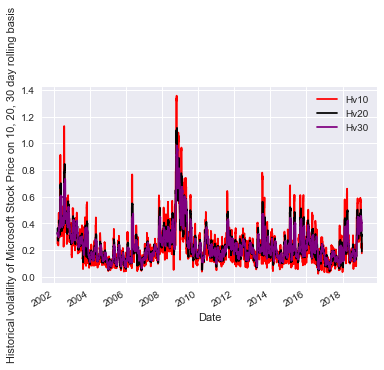

In [117]:
df.Hv10.plot(color = 'red')
df.Hv20.plot(color = 'black')
df.Hv30.plot(color = 'purple')
plt.xlabel('Date')
plt.ylabel('Historical volatility of Microsoft Stock Price on 10, 20, 30 day rolling basis')
plt.legend()

This graph clearly demonstrates the drawbacks of modelling volatilities under a Gaussian distribution. 

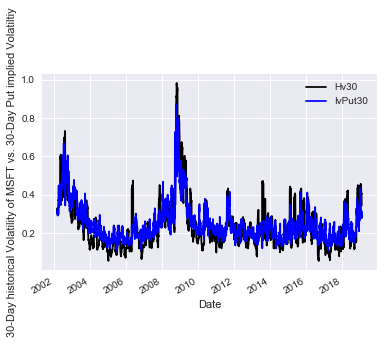

In [118]:
df.Hv30.plot(color = 'black')
df.IvPut30.plot(color = 'blue')
plt.xlabel('Date')
plt.ylabel('30-Day historical Volatility of MSFT vs. 30-Day Put implied Volatiltiy') #<-- calculated through put options BS
plt.legend()

In [119]:
vol_pd = (df.IvPut30 / df.Hv30)- 1
vol_pd = vol_pd.to_frame()
vol_pd.head()

,0
Date,
2002-03-15,-0.031279
2002-03-18,-0.027854
2002-03-19,-0.052431
2002-03-20,-0.035487
2002-03-21,-0.079351


In [120]:
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

s = vol_pd.style.applymap(_color_red_or_green).format('{:.2%}')
s

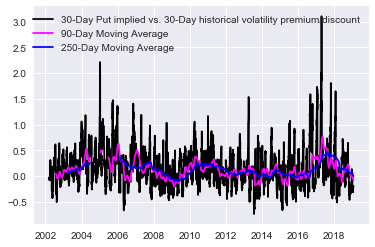

In [121]:
vol_pd_MA750 = vol_pd.rolling(window = 750).mean()
vol_pd_MA90 = vol_pd.rolling(window = 90).mean()
vol_pd_MA250 = vol_pd.rolling(window = 250).mean()
plt.plot(vol_pd, color = 'black', label = '30-Day Put implied vs. 30-Day historical volatility premium/discount')
plt.plot(vol_pd_MA90, color = 'magenta', label = '90-Day Moving Average' )
plt.plot(vol_pd_MA250, color = 'blue', label = '250-Day Moving Average');
plt.legend()

Looking at the difference between realized and implied volatility of any asset class gives a gauge on market sentiment. Extended levels of volatility discounts represent complacency and extended levels of volatility premiums represent moments of panic. 

In the above chart, the volatility event of February 2018 stands out. 

In [122]:
vol_pd.describe()

,0
count,4231.000000
mean,0.132246
std,0.376690
min,-0.739961
25%,-0.127661
50%,0.086560
75%,0.326893
max,3.107325


We can use the Sapiro-Wilk Test, among many, to see if the data satisfies a Gaussian distribution. Before, we have visually seen that this is not the case. The result from the test also indicate that the implied volatility premium/discount is not normally distributed. The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

The shapiro SciPy function will calculate the Shapiro-Wilk on a given dataset. The function returns both the W-statistic calculated by the test and the p-value.

In [123]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro

# normality test
stat, p = shapiro(vol_pd.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')



Statistics=0.941, p=0.000
Sample does not look Gaussian (reject H0)


# 4. Critique on the assumptions behind the Modern Theory of Finance <a name = "Critique one the assumptions behind the Modern Theory of Finance"></a>

All models by necessity distort reality in one way or another. In the section we review Mandelbrot's critique on the assumptions of orthodox financial theory from his seminal book: 'the (mis)Behaviour of Markets'. In Mandelbrot's words: 'The assumptions of orthodox financial theory are at least as absurd, if viewed in isolation'. We consider a few of his main arguments. 

### 1. People are rational and aim to get rich
In this context markets are efficient, meaning that when presented with all the relevant information about a stock or a bond, individual investors can and will make the rational choice leading to the greatest possible wealth and utility. Investors will not ignore important information. They will not become philantrophists. Instead they will behave as the most rational, clear-thinking and self-interested individuals, as Adam Smith would imagine. By behaving as described above, they will make markets efficient driving prices of individual assets to the 'fair' price. 

However, in reality, people do not only think in some sort of linear theoretical utility measured in wealth. In fact, the refutation of the aferomentioned observations created a new field in economics, called behavioral economics. In reality, emotions distort decisions, people misinterpret information and probabilities are often miscalculated. The interested reader can consult the seminal book of nobel laureat Daniel Kahneman, 'Thinking, Fast and Slow'. 

### 2. All investors are alike
In this context, investors have homogenous expectations. They are price-takers and not price-makers. A paragon to physics is that investors can be described as molecules in the perfect, idealized gas of a physicist: identical and individually negligible. Given the same information, they would make the same decision. 

In reality, every participant in a market is unique. Some pursue 'value' strategies, others 'growth' strategies. The quants use statistical arbitrage and momentum models. Every investors has different needs, risk-tolerance and time-horizon. The day-traders might hold a stock for a couple of hours, while adults investing for their retirement hold it for 30 years. Once you drop the assumption of homogeneity, new and complicated things happen to the models described in this paper. From a well-behaved 'linear' system in which one factor adds predictably to the next, we get a chaotic dynamic model in which multiple factors interact with eachother and no equilibrium is ever achieved. 

### 3. Price change is continuous 
In the previous figures we have presented the Brownian motion for the Dow Jones Industrials Average. Underlying the Brownian motion process, is that prices change continuously. Quotes do not jump up or down by several points at a time. They move smoothly from one value to the next. For the price of Microsoft to get from 45 to 50 USD it needs to pass through all the values in between. In the case of assuming continuous price changes, one can use the well-stocked math of continuous functions and differential equations. As we have seen in the section about Markowitz portfolio theory, Markowitz central upcoming was to reduce all decisions to two simple factors, the expected return and the variance of expected prices. From a mathematical and modelling standpoint, this simplification only works when assuming continuous price change. 

This assumptions stands in stark contrast to what happens in reality. On a fundamental basis, brokers often quote prices in round numbers, skipping intermediate values. Nevertheless, almost every day order imbalances occur, where sell and buy orders did not match and market-makers have to raise or lower their prices until they do. In Mandelbrot's words: 'Discontinuity, far from being an anomaly best ignored, is an essential ingredient of markets that helps set finance apart from the natural sciences.'

### 4. Prices follow a Brownian motion
Brownian motion is a term borrowed from physics for the motion of a molecule in a uniformly warm medium. The french mathematician Louis Bachelier had suggested that this process can also be used to describe price variation. Under a Brownian motion we identify that price changes happen independently of the previous price changes. The prices of last week, month or year do not influence tommorrows prices. Further we assume, that price changes are stationary. The process generating the price changes, whatever it may be, stays the same over time. The third assumption is that price changes follow the bell curve- distributed according to a normal distribution. 

This set of assumptions is the one most clearly contradicted by the facts, as we have shown in the previous section. 

# 5. Conclusion and summary <a name = "Conclusion and summary"></a>

The Modern Portfolio Theory derives all of its main assumptions from the two basic concepts of risk and return, which were presented - among others - with the Expected Portfolio Return, Volatility and Coefficient of Correlation. 

To derive the Markowitz Efficient Frontier, so basically the key result of the Modern Portfolio Theory Chapter of our paper, we created diverse portfolios from sample stocks we selected, determined the respective portfolio return and risk metrics as well as plotted the corresponding portfolios graphically. Special Portfolios, namely the efficient portfolio with the highest superior return for a standarized risk level (Sharpe Ratio) and the Minimum Variance Portfolio (MVP) were presented in that context. Finally, the corresponding efficient frontier was shown.

Extending the aforementioned results, we introduced the CAPM model, its basic assumptions and consideration. We attempted to recreate its key formulas by deriving them from an examplary two-asset portfolio. The Beta Coefficient, basically the key metric of the CAPM with its assumption that all risk is market risk in efficient portfolios, is determined and we thereby start to measure the sensitivity of individual stock prices to the overall market variation. Additionally, we provided interesting insights into the correlation matrix and the topic of volalitiy, both of which are key ingrediants to the CAPM in general and the beta coefficient in specific.

# 6. Sources <a name = "Sources"></a>

This Paper contains verbatim quotes from the following sources:

- Brealey, R., Myers, S., & Allen, F. (2016). *Principles of corporate finance. McGraw-Hill Education Ltd*.

- Elton, E., & Gruber, M. (2014). *Modern Portfolio Theory and Investment Analysis. Hoboken*, NJ: John Wiley & Sons, Inc.

- Francis, J., & Kim, D. (2013). *Modern portfolio theory*. Hoboken, N.J.: J. Wiley & Sons.

- Investopedia. (2019). Modern Portfolio Theory (MPT). Retrieved from https://www.investopedia.com/walkthrough/fund-guide/introduction/1/modern-portfolio-theory-mpt.aspx

- Markowitz, H. (2008). *Portfolio Selection*. München: FinanzBuch-Verl.

- Mondello, E. (2017). *Finance*. Springer Gabler.

- Mondello, E. (2015). *Portfoliomanagement*. Wiesbaden: Gabler.

- Schmid, M. (2018). *Finance* (Lecture Slides). St. Gallen: University of St. Gallen.

- Sigman, K. (2005). *Capital Asset Pricing Model*. New York: Columbia Business School. Retrieved from http://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-CAPM.pdf

- UNSW Business School. (n.d.). *Capital Asset Pricing Model* (Lecture Slides). Sydney: UNSW Business School. Retrieved from http://research.economics.unsw.edu.au/jmorley/econ487/CAPM_lecture.pdf
